In [17]:
import numpy as np

# Global Parameters
S0 = 80
K = 80
T = 0.25
r = 0.055
v0 = 0.032
kappa = 1.85
theta = 0.045
sigma_v = 0.35
n_steps = 100
n_paths = 100000 # Monte Carlo paths
dt = T / n_steps



In [19]:

#Q5 & Q6: European Option Pricing Using Heston Model (Monte Carlo Simulation)

def heston_mc_parity_safe(S0, K, T, r, v0, kappa, theta, sigma_v, rho, n_paths, n_steps):
    np.random.seed(42)
    dt = T / n_steps
    S = np.full(n_paths, S0, dtype=float)
    v = np.full(n_paths, v0, dtype=float)

    for _ in range(n_steps):
        z1 = np.random.normal(size=n_paths)
        z2 = np.random.normal(size=n_paths)
        w1 = z1
        w2 = rho * z1 + np.sqrt(1 - rho**2) * z2
        v = np.maximum(0, v + kappa * (theta - v) * dt + sigma_v * np.sqrt(v * dt) * w2)
        S *= np.exp((r - 0.5 * v) * dt + np.sqrt(v * dt) * w1)

    call_payoffs = np.maximum(S - K, 0)
    call_price = np.exp(-r * T) * np.mean(call_payoffs)

    discounted_strike = K * np.exp(-r * T)
    put_price = call_price - (S0 - discounted_strike)

    return S, round(call_price, 2), round(put_price, 2)

# Run for rho = -0.3 and -0.7
results = {}
for rho in [-0.3, -0.7]:
    S_paths, call, put = heston_mc_parity_safe(S0, K, T, r, v0, kappa, theta, sigma_v, rho, n_paths, n_steps)
    results[rho] = (call, put)

# Print results
for rho, (call, put) in results.items():
    print(f"Correlation {rho} | Call: ${call} | Put: ${put}")


Correlation -0.3 | Call: $2.88 | Put: $1.79
Correlation -0.7 | Call: $2.13 | Put: $1.03


In [21]:
#Q7: Numerical Delta and Gamma

def numerical_greeks_shared(S0, K, T, r, v0, kappa, theta, sigma_v, rho, h=0.5):
    np.random.seed(100)
    S_up = np.full(n_paths, S0 + h, dtype=float)
    S_mid = np.full(n_paths, S0, dtype=float)
    S_down = np.full(n_paths, S0 - h, dtype=float)

    v_up = np.full(n_paths, v0, dtype=float)
    v_mid = np.full(n_paths, v0, dtype=float)
    v_down = np.full(n_paths, v0, dtype=float)

    for _ in range(n_steps):
        z1 = np.random.normal(size=n_paths)
        z2 = np.random.normal(size=n_paths)
        w1 = z1
        w2 = rho * z1 + np.sqrt(1 - rho**2) * z2

        for S, v in zip([S_up, S_mid, S_down], [v_up, v_mid, v_down]):
            v[:] = np.maximum(0, v + kappa * (theta - v) * dt + sigma_v * np.sqrt(v * dt) * w2)
            S[:] *= np.exp((r - 0.5 * v) * dt + np.sqrt(v * dt) * w1)

    call_up = np.exp(-r * T) * np.mean(np.maximum(S_up - K, 0))
    call_mid = np.exp(-r * T) * np.mean(np.maximum(S_mid - K, 0))
    call_down = np.exp(-r * T) * np.mean(np.maximum(S_down - K, 0))

    delta = (call_up - call_down) / (2 * h)
    gamma = (call_up - 2 * call_mid + call_down) / (h ** 2)

    return round(delta, 4), round(gamma, 4)

# Compute for both rho values
for rho in [-0.3, -0.7]:
    delta, gamma = numerical_greeks_shared(S0, K, T, r, v0, kappa, theta, sigma_v, rho)
    print(f"Correlation {rho} | Delta: {delta} | Gamma: {gamma}")



Correlation -0.3 | Delta: 0.5387 | Gamma: 0.0566
Correlation -0.7 | Delta: 0.4838 | Gamma: 0.0572


In [23]:

#Q13: American Call Option Under Heston via Binomial Tree

def binomial_american_call(S0, K, T, r, sigma, N=100):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    prices = np.zeros(N + 1)
    values = np.zeros(N + 1)

    for i in range(N + 1):
        prices[i] = S0 * (u ** (N - i)) * (d ** i)
        values[i] = max(prices[i] - K, 0)

    for j in range(N - 1, -1, -1):
        for i in range(j + 1):
            prices[i] = prices[i] / u
            values[i] = max(prices[i] - K, np.exp(-r * dt) * (p * values[i] + (1 - p) * values[i + 1]))

    return round(values[0], 2)

# Use Heston long-run vol ≈ sqrt(theta)
sigma_equiv = np.sqrt(theta)
am_call_price = binomial_american_call(S0, K, T, r, sigma=sigma_equiv)
print(f"American Call Price (Approx): ${am_call_price}")


American Call Price (Approx): $3.93


In [25]:

# Q14: European Up-and-In Call Option Under Heston

def up_and_in_call_from_paths(S0, K, H, T, r, v0, kappa, theta, sigma_v, rho, n_paths, n_steps):
    np.random.seed(42)
    S = np.full(n_paths, S0, dtype=float)
    v = np.full(n_paths, v0, dtype=float)
    hit_barrier = np.zeros(n_paths, dtype=bool)

    for _ in range(n_steps):
        z1 = np.random.normal(size=n_paths)
        z2 = np.random.normal(size=n_paths)
        w1 = z1
        w2 = rho * z1 + np.sqrt(1 - rho**2) * z2
        v = np.maximum(0, v + kappa * (theta - v) * dt + sigma_v * np.sqrt(v * dt) * w2)
        S *= np.exp((r - 0.5 * v) * dt + np.sqrt(v * dt) * w1)
        hit_barrier |= (S >= H)

    payoffs = np.where(hit_barrier, np.maximum(S - K, 0), 0)
    return round(np.exp(-r * T) * np.mean(payoffs), 2)

# Q14: Up-and-In Call with barrier = strike = 95 using rho = -0.7
up_in_price = up_and_in_call_from_paths(S0, K=95, H=95, T=T, r=r,
                                        v0=v0, kappa=kappa, theta=theta,
                                        sigma_v=sigma_v, rho=-0.7,
                                        n_paths=n_paths, n_steps=n_steps)
print(f"European Up-and-In Call Price: ${up_in_price}")


European Up-and-In Call Price: $0.01


# QUESTION 8

In [18]:
import numpy as np
import pandas as pd

def merton_jump_diffusion_price(S0, K, r, sigma, T, mu_j, delta_j, lam, option_type="call", n_paths=100000, n_steps=100):
    dt = T / n_steps
    drift = r - lam * (np.exp(mu_j + 0.5 * delta_j ** 2) - 1) - 0.5 * sigma ** 2
    prices = np.full(n_paths, S0, dtype=np.float64)  # Ensure correct data type
    
    for step in range(n_steps):
        z = np.random.normal(0, 1, n_paths)
        poisson = np.random.poisson(lam * dt, n_paths)
        jump_magnitude = np.random.normal(mu_j, delta_j, n_paths)
        jump_factor = np.exp(jump_magnitude * poisson)
        prices *= np.exp(drift * dt + sigma * np.sqrt(dt) * z) * jump_factor

    if option_type == "call":
        payoffs = np.maximum(prices - K, 0)
    else:
        payoffs = np.maximum(K - prices, 0)

    discounted_payoff = np.exp(-r * T) * payoffs
    return round(np.mean(discounted_payoff), 4)

# Parameters
S0 = 80
K = 80
r = 0.055
sigma = 0.35
T = 0.25
mu_j = -0.5
delta_j = 0.22
lam = 0.75
n_paths = 100000
n_steps = 100

# Calculate option prices for Question 8
call_price_q8 = merton_jump_diffusion_price(S0, K, r, sigma, T, mu_j, delta_j, lam, "call")
put_price_q8 = merton_jump_diffusion_price(S0, K, r, sigma, T, mu_j, delta_j, lam, "put")

# Display results in a table
df_q8 = pd.DataFrame({
    "Option Type": ["Call", "Put"],
    "Strike": [K, K],
    "λ (Jump Intensity)": [lam, lam],
    "Price": [call_price_q8, put_price_q8]
})

print("✅ Q8: European Option Prices using Merton Model (λ = 0.75)")
print(df_q8)


✅ Q8: European Option Prices using Merton Model (λ = 0.75)
  Option Type  Strike  λ (Jump Intensity)   Price
0        Call      80                0.75  8.2684
1         Put      80                0.75  7.1743


In [19]:
# Compute theoretical value from put-call parity
put_call_parity_value = S0 - K * np.exp(-r * T)

# Compute difference from actual values
difference_q8 = abs(call_price_q8 - put_price_q8 - put_call_parity_value)

print(f"Put-Call Parity Value: {put_call_parity_value:.4f}")
print(f"Computed Difference (Question 8): {difference_q8:.4f}")

# Check if the difference is small
if difference_q8 < 0.01:  # Allowing slight numerical precision issues
    print("✅ The results from Question 8 satisfy put-call parity!")
else:
    print("❌ There might be a deviation from put-call parity.")


Put-Call Parity Value: 1.0925
Computed Difference (Question 8): 0.0016
✅ The results from Question 8 satisfy put-call parity!


# QUESTION 9

In [20]:

lam_q9 = 0.25


call_price_q9 = merton_jump_diffusion_price(S0, K, r, sigma, T, mu_j, delta_j, lam_q9, "call")
put_price_q9 = merton_jump_diffusion_price(S0, K, r, sigma, T, mu_j, delta_j, lam_q9, "put")


df_q9 = pd.DataFrame({
    "Option Type": ["Call", "Put"],
    "Strike": [K, K],
    "λ (Jump Intensity)": [lam_q9, lam_q9],
    "Price": [call_price_q9, put_price_q9]
})

print("✅ Q9: European Option Prices using Merton Model (λ = 0.25)")
print(df_q9)


✅ Q9: European Option Prices using Merton Model (λ = 0.25)
  Option Type  Strike  λ (Jump Intensity)   Price
0        Call      80                0.25  6.8220
1         Put      80                0.25  5.7428


In [21]:

lhs_q9 = call_price_q9 + K * np.exp(-r * T)
rhs_q9 = put_price_q9 + S0

print(f"\nPut-Call Parity Check for λ = 0.25:")
print(f"LHS (Call + PV(K)) = {call_price_q9:.4f} + {K}*e^(-{r}*{T}) = {lhs_q9:.4f}")
print(f"RHS (Put + S0)     = {put_price_q9:.4f} + {S0} = {rhs_q9:.4f}")
print("✅ Parity Satisfied" if abs(lhs_q9 - rhs_q9) < 0.01 else "❌ Parity Not Satisfied")



Put-Call Parity Check for λ = 0.25:
LHS (Call + PV(K)) = 6.8220 + 80*e^(-0.055*0.25) = 85.7295
RHS (Put + S0)     = 5.7428 + 80 = 85.7428
❌ Parity Not Satisfied


In [22]:

lam_q9 = 0.25


call_price_q9 = merton_jump_diffusion_price(S0, K, r, sigma, T, mu_j, delta_j, lam_q9, "call")
put_price_q9 = merton_jump_diffusion_price(S0, K, r, sigma, T, mu_j, delta_j, lam_q9, "put")


df_q9 = pd.DataFrame({
    "Option Type": ["Call", "Put"],
    "Strike": [K, K],
    "λ (Jump Intensity)": [lam_q9, lam_q9],
    "Price": [call_price_q9, put_price_q9]
})

print("✅ Q9: European Option Prices using Merton Model (λ = 0.25)")
print(df_q9)


✅ Q9: European Option Prices using Merton Model (λ = 0.25)
  Option Type  Strike  λ (Jump Intensity)   Price
0        Call      80                0.25  6.8131
1         Put      80                0.25  5.7350


In [23]:

put_call_parity_value_q9 = S0 - K * np.exp(-r * T)


difference_q9 = abs(call_price_q9 - put_price_q9 - put_call_parity_value_q9)

print(f"Put-Call Parity Value: {put_call_parity_value_q9:.4f}")
print(f"Computed Difference (Question 9): {difference_q9:.4f}")


if difference_q9 < 0.01:  
    print("✅ The results from Question 9 satisfy put-call parity!")
else:
    print("❌ There might be a deviation from put-call parity.")


Put-Call Parity Value: 1.0925
Computed Difference (Question 9): 0.0144
❌ There might be a deviation from put-call parity.


In [24]:
import numpy as np
import pandas as pd

def merton_jump_diffusion_price(S0, K, r, sigma, T, mu_j, delta_j, lam, option_type="call", n_paths=500000, n_steps=500):
    dt = T / n_steps
    drift = r - lam * (np.exp(mu_j + 0.5 * delta_j ** 2) - 1) - 0.5 * sigma ** 2
    prices = np.full(n_paths, S0, dtype=np.float64)  # Ensuring correct data type

    for step in range(n_steps):
        z = np.random.normal(0, 1, n_paths)
        poisson = np.random.poisson(lam * dt, n_paths)
        jump_magnitude = np.random.normal(mu_j, delta_j, n_paths)
        jump_factor = np.exp(jump_magnitude * poisson)
        prices *= np.exp(drift * dt + sigma * np.sqrt(dt) * z) * jump_factor

    if option_type == "call":
        payoffs = np.maximum(prices - K, 0)
    else:
        payoffs = np.maximum(K - prices, 0)

    discounted_payoff = np.exp(-r * T) * payoffs
    return round(np.mean(discounted_payoff), 6)  


S0 = 80
K = 80
r = 0.055
sigma = 0.35
T = 0.25
mu_j = -0.5
delta_j = 0.22
lam_q9 = 0.25


call_price_q9 = merton_jump_diffusion_price(S0, K, r, sigma, T, mu_j, delta_j, lam_q9, "call")
put_price_q9 = merton_jump_diffusion_price(S0, K, r, sigma, T, mu_j, delta_j, lam_q9, "put")


df_q9 = pd.DataFrame({
    "Option Type": ["Call", "Put"],
    "Strike": [K, K],
    "λ (Jump Intensity)": [lam_q9, lam_q9],
    "Price": [call_price_q9, put_price_q9]
})

print("✅ Q9: European Option Prices using Merton Model (λ = 0.25) with higher accuracy")
print(df_q9)


put_call_parity_value_q9 = S0 - K * np.exp(-r * T)
difference_q9 = abs(call_price_q9 - put_price_q9 - put_call_parity_value_q9)

print(f"Put-Call Parity Value: {put_call_parity_value_q9:.6f}")
print(f"Computed Difference (Question 9): {difference_q9:.6f}")

# Check if the difference is small
if difference_q9 < 0.01:  # Allowing slight numerical precision issues
    print("✅ The results now satisfy put-call parity!")
else:
    print("❌ The deviation still exists, but should be smaller.")


✅ Q9: European Option Prices using Merton Model (λ = 0.25) with higher accuracy
  Option Type  Strike  λ (Jump Intensity)     Price
0        Call      80                0.25  6.838632
1         Put      80                0.25  5.749366
Put-Call Parity Value: 1.092472
Computed Difference (Question 9): 0.003206
✅ The results now satisfy put-call parity!


# QUESTION 10

In [25]:
import numpy as np

def compute_delta_gamma(S0, K, r, sigma, T, mu_j, delta_j, lam, option_type="call", h=0.01):
    # Compute option prices at S0 + h, S0, and S0 - h
    C_plus = merton_jump_diffusion_price(S0 + h, K, r, sigma, T, mu_j, delta_j, lam, option_type)
    C_minus = merton_jump_diffusion_price(S0 - h, K, r, sigma, T, mu_j, delta_j, lam, option_type)
    C_base = merton_jump_diffusion_price(S0, K, r, sigma, T, mu_j, delta_j, lam, option_type)

    # Compute Delta
    delta = (C_plus - C_minus) / (2 * h)

    # Compute Gamma
    gamma = (C_plus - 2 * C_base + C_minus) / (h ** 2)

    return round(delta, 6), round(gamma, 6)

# Parameters
S0 = 80
K = 80
r = 0.055
sigma = 0.35
T = 0.25
mu_j = -0.5
delta_j = 0.22

# Compute Delta & Gamma for Question 8 (λ = 0.75)
lam_q8 = 0.75
delta_q8_call, gamma_q8_call = compute_delta_gamma(S0, K, r, sigma, T, mu_j, delta_j, lam_q8, "call")
delta_q8_put, gamma_q8_put = compute_delta_gamma(S0, K, r, sigma, T, mu_j, delta_j, lam_q8, "put")

# Compute Delta & Gamma for Question 9 (λ = 0.25)
lam_q9 = 0.25
delta_q9_call, gamma_q9_call = compute_delta_gamma(S0, K, r, sigma, T, mu_j, delta_j, lam_q9, "call")
delta_q9_put, gamma_q9_put = compute_delta_gamma(S0, K, r, sigma, T, mu_j, delta_j, lam_q9, "put")

# Display results in a table
import pandas as pd

df_q10 = pd.DataFrame({
    "Option Type": ["Call (λ=0.75)", "Put (λ=0.75)", "Call (λ=0.25)", "Put (λ=0.25)"],
    "Delta (Δ)": [delta_q8_call, delta_q8_put, delta_q9_call, delta_q9_put],
    "Gamma (Γ)": [gamma_q8_call, gamma_q8_put, gamma_q9_call, gamma_q9_put]
})

print("✅ Q10: Delta & Gamma for Merton Model Options")
print(df_q10)


✅ Q10: Delta & Gamma for Merton Model Options
     Option Type  Delta (Δ)  Gamma (Γ)
0  Call (λ=0.75)    1.39990    -471.76
1   Put (λ=0.75)    0.18450    -129.30
2  Call (λ=0.25)    0.15565    -585.95
3   Put (λ=0.25)    1.30745    -159.53


# Q15

In [26]:
import numpy as np
import pandas as pd

def merton_down_in_put(S0, K, r, sigma, T, mu_j, delta_j, lam, barrier, n_paths=500000, n_steps=500):
    dt = T / n_steps
    drift = r - lam * (np.exp(mu_j + 0.5 * delta_j ** 2) - 1) - 0.5 * sigma ** 2
    prices = np.full(n_paths, S0, dtype=np.float64)
    barrier_hit = np.zeros(n_paths, dtype=bool)  # Track barrier breach

    for step in range(n_steps):
        z = np.random.normal(0, 1, n_paths)
        poisson = np.random.poisson(lam * dt, n_paths)
        jump_magnitude = np.random.normal(mu_j, delta_j, n_paths)
        jump_factor = np.exp(jump_magnitude * poisson)
        prices *= np.exp(drift * dt + sigma * np.sqrt(dt) * z) * jump_factor

        # Check if barrier is breached
        barrier_hit |= (prices <= barrier)

    # Compute payoffs only for paths where barrier was breached
    payoffs = np.maximum(K - prices, 0) * barrier_hit
    discounted_payoff = np.exp(-r * T) * payoffs

    return round(np.mean(discounted_payoff), 6)

# Parameters
S0 = 80
K = 65  # Strike price
r = 0.055
sigma = 0.35
T = 0.25
mu_j = -0.5
delta_j = 0.22
lam_q8 = 0.75  # Jump intensity from Question 8
barrier = 65  # Barrier level

# Compute Down-and-In Put Price
pdi_price_q15 = merton_down_in_put(S0, K, r, sigma, T, mu_j, delta_j, lam_q8, barrier)

# Display result
df_q15 = pd.DataFrame({
    "Option Type": ["Down-and-In Put"],
    "Strike": [K],
    "Barrier Level": [barrier],
    "Jump Intensity (λ)": [lam_q8],
    "Price": [pdi_price_q15]
})

print("✅ Q15: European Down-and-In Put Option Pricing using Merton Model")
print(df_q15)


✅ Q15: European Down-and-In Put Option Pricing using Merton Model
       Option Type  Strike  Barrier Level  Jump Intensity (λ)     Price
0  Down-and-In Put      65             65                0.75  2.761321


## MEMBER C: MODEL VALIDATION

## Q11: Check the pricing of Member A: Heston model under Monte Carlo Simulation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import pandas as pd

In [2]:
#Member A
# Global Parameters
S0 = 80
K = 80
T = 0.25
r = 0.055
v0 = 0.032
kappa = 1.85
theta = 0.045
sigma_v = 0.35
n_steps = 100
n_paths = 100000 # Monte Carlo paths
dt = T / n_steps

In [3]:
#Q5 & Q6: European Option Pricing Using Heston Model (Monte Carlo Simulation)

def heston_mc_parity_safe(S0, K, T, r, v0, kappa, theta, sigma_v, rho, n_paths, n_steps):
    np.random.seed(42)
    dt = T / n_steps
    S = np.full(n_paths, S0, dtype=float)
    v = np.full(n_paths, v0, dtype=float)

    for _ in range(n_steps):
        z1 = np.random.normal(size=n_paths)
        z2 = np.random.normal(size=n_paths)
        w1 = z1
        w2 = rho * z1 + np.sqrt(1 - rho**2) * z2
        v = np.maximum(0, v + kappa * (theta - v) * dt + sigma_v * np.sqrt(v * dt) * w2)
        S *= np.exp((r - 0.5 * v) * dt + np.sqrt(v * dt) * w1)

    call_payoffs = np.maximum(S - K, 0)
    call_price = np.exp(-r * T) * np.mean(call_payoffs)

    discounted_strike = K * np.exp(-r * T)
    put_price = call_price - (S0 - discounted_strike)  # Member A does not simulate the put separately, instead, the put is derived directly from the parity relationship.

    return S, round(call_price, 2), round(put_price, 2)

# Run for rho = -0.3 and -0.7
results = {}
for rho in [-0.3, -0.7]:
    S_paths, call, put = heston_mc_parity_safe(S0, K, T, r, v0, kappa, theta, sigma_v, rho, n_paths, n_steps)
    results[rho] = (call, put)

# Print results
for rho, (call, put) in results.items():
    print(f"Correlation {rho} | Call: ${call} | Put: ${put}")

Correlation -0.3 | Call: $2.88 | Put: $1.79
Correlation -0.7 | Call: $2.13 | Put: $1.03


In [4]:
#Use the code of Member A but simulate Put and Call path separately
# Independent Heston Monte Carlo Simulation for Call
def heston_mc_call(S0, K, T, r, v0, kappa, theta, sigma_v, rho, n_paths, n_steps):
    dt = T / n_steps
    S = np.full(n_paths, S0, dtype=float)
    v = np.full(n_paths, v0, dtype=float)
    np.random.seed(42)
    for _ in range(n_steps):
        z1 = np.random.normal(size=n_paths)
        z2 = np.random.normal(size=n_paths)
        w1 = z1
        w2 = rho * z1 + np.sqrt(1 - rho**2) * z2
        v = np.maximum(0, v + kappa * (theta - v) * dt + sigma_v * np.sqrt(v * dt) * w2)
        S *= np.exp((r - 0.5 * v) * dt + np.sqrt(v * dt) * w1)
    call_price = np.exp(-r * T) * np.mean(np.maximum(S - K, 0))
    return call_price

# Independent Heston Monte Carlo Simulation for Put
def heston_mc_put(S0, K, T, r, v0, kappa, theta, sigma_v, rho, n_paths, n_steps):
    dt = T / n_steps
    S = np.full(n_paths, S0, dtype=float)
    v = np.full(n_paths, v0, dtype=float)
    np.random.seed(42)
    for _ in range(n_steps):
        z1 = np.random.normal(size=n_paths)
        z2 = np.random.normal(size=n_paths)
        w1 = z1
        w2 = rho * z1 + np.sqrt(1 - rho**2) * z2
        v = np.maximum(0, v + kappa * (theta - v) * dt + sigma_v * np.sqrt(v * dt) * w2)
        S *= np.exp((r - 0.5 * v) * dt + np.sqrt(v * dt) * w1)
    put_price = np.exp(-r * T) * np.mean(np.maximum(K - S, 0))
    return put_price

# Run simulations
call_price = heston_mc_call(S0, K, T, r, v0, kappa, theta, sigma_v, rho, n_paths, n_steps)
put_price = heston_mc_put(S0, K, T, r, v0, kappa, theta, sigma_v, rho, n_paths, n_steps)

# Compute put-call parity RHS
rhs = S0 - K * np.exp(-r * T)
diff = call_price - put_price - rhs

(call_price, put_price, rhs, diff)

(2.127318777225357, 3.4410698179572488, 1.092472042636473, -2.406223083368365)

#### Put-Call Parity does not hold in Member A's simulation. There are several possible reasons:
 - Not set a common random seed before generating random numbers.
 - Calculating the price of a non-independently simulated Put option. In Member A's code, only Call is simulated correctly, while Put is derived from Call price. 
 - Not using the covariance matrix properly: Member A only creates z1, z2 and then combines them using a linear formula.
 - Member A uses v⋅dt directly without controlling the small value of v ⇒ easily causing errors
 - Insufficient number of time steps or paths (discretization error).

In [5]:
#Fix the code of Member A using the same random set
import numpy as np

# === Parameters ===
S0 = 80
K = 80
T = 0.25
r = 0.055
v0 = 0.032
kappa = 1.85
theta = 0.045
sigma_v = 0.35
rho = -0.9
I = 100000   # paths
M0 = 500     # time steps per year
M = int(M0 * T)
dt = T / M

# === Shared Random Numbers ===
np.random.seed(42)
rand = np.random.standard_normal((2, M + 1, I))
cho_matrix = np.linalg.cholesky([[1.0, rho], [rho, 1.0]])

# === Volatility Process ===
def SDE_vol(v0, kappa, theta, sigma, M, I, rand, row, cho_matrix):
    v = np.zeros((M + 1, I))
    v[0] = v0
    sdt = np.sqrt(dt)
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        v[t] = np.maximum(0, v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * ran[row] * sdt)
    return v

# === Stock Process ===
def Heston_paths(S0, r, v, row, cho_matrix):
    S = np.zeros((M + 1, I))
    S[0] = S0
    sdt = np.sqrt(dt)
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        S[t] = S[t - 1] * np.exp((r - 0.5 * v[t - 1]) * dt + np.sqrt(v[t - 1]) * ran[row] * sdt)
    return S

# === Option Pricing ===
def heston_call_mc(S, K, r, T, t):
    payoff = np.maximum(S[-1] - K, 0)
    return np.exp(-r * (T - t)) * np.mean(payoff)

def heston_put_mc(S, K, r, T, t):
    payoff = np.maximum(K - S[-1], 0)
    return np.exp(-r * (T - t)) * np.mean(payoff)

# === Run Simulation Once ===
V = SDE_vol(v0, kappa, theta, sigma_v, M, I, rand, 1, cho_matrix)
S = Heston_paths(S0, r, V, 0, cho_matrix)

call_price = heston_call_mc(S, K, r, T, 0)
put_price = heston_put_mc(S, K, r, T, 0)
rhs = S0 - K * np.exp(-r * T)
diff = call_price - put_price - rhs

# === Output ===
print(f"Call Price: {call_price:.6f}")
print(f"Put Price: {put_price:.6f}")
print(f"S0 - K*exp(-rT): {rhs:.6f}")
print(f"Diff: {diff:.6f}")


Call Price: 3.500830
Put Price: 2.422965
S0 - K*exp(-rT): 1.092472
Diff: -0.014607


The small deviation (≈ -0.014607) is expected in the Monte Carlo simulation because:
 - The simulation uses a finite number of steps (M = 500) and a finite number of paths (I = 10,000)
 - In particular, the Heston model has stochastic volatility, so the volatility is higher than the Black-Scholes model.
However, the put-call parity is still almost kept within an acceptable error, showing that:
 - The Heston model still satisfies the theoretical condition of no arbitrage
 - The Monte Carlo implementation is reasonable, without too much deviation

### Member A's code will be rewritten to fix the errors mentioned above, then test if Put-Call Parity holds.

In [6]:
#Reuse Parameters from Member A
S0 = 80
K = 80
r = 0.055
T = 0.25
v0 = 0.032
kappa_v = 1.85
theta_v = 0.045
sigma_v = 0.35
rho = -0.9

M0 = 500
M = int(M0 * T)
I = 10000
dt = T / M

In [7]:
# === Random Number Generation ===
np.random.seed(42)
rand = np.random.standard_normal((2, M + 1, I))
cho_matrix = np.linalg.cholesky([[1.0, rho], [rho, 1.0]])

# === Volatility Process (CIR) ===
def SDE_vol(v0, kappa, theta, sigma, T, M, I, rand, row, cho_matrix):
    dt = T / M
    v = np.zeros((M + 1, I))
    v[0] = v0
    sdt = np.sqrt(dt)
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        v[t] = np.maximum(0, v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * ran[row] * sdt)
    return v


In [8]:
# === Price Process ===
def Heston_paths(S0, r, v, row, cho_matrix):
    S = np.zeros((M + 1, I))
    S[0] = S0
    sdt = np.sqrt(dt)
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        S[t] = S[t - 1] * np.exp((r - 0.5 * v[t - 1]) * dt + np.sqrt(v[t - 1]) * ran[row] * sdt)
    return S

# === Option Pricing ===
def heston_call_mc(S, K, r, T, t):
    payoff = np.maximum(S[-1] - K, 0)
    return np.exp(-r * (T - t)) * np.mean(payoff)

def heston_put_mc(S, K, r, T, t):
    payoff = np.maximum(K - S[-1], 0)
    return np.exp(-r * (T - t)) * np.mean(payoff)

# === Simulation ===
V = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, I, rand, 1, cho_matrix)
S = Heston_paths(S0, r, V, 0, cho_matrix)

# === Price Computation ===
call_price = heston_call_mc(S, K, r, T, 0)
put_price = heston_put_mc(S, K, r, T, 0)
parity_lhs = call_price - put_price
parity_rhs = S0 - K * np.exp(-r * T)
diff = parity_lhs - parity_rhs

(call_price, put_price, parity_rhs, diff)

(3.48046469696286, 2.4791441848368923, 1.092472042636473, -0.09115153051050529)

## Q11: Check the pricing of Member B: Merton model 


In [9]:
#Member B
# Merton Jump Diffusion Model for European Options Pricing

def merton_jump_diffusion_price(S0, K, r, sigma, T, mu_j, delta_j, lam, option_type="call", n_paths=100000, n_steps=100):
    dt = T / n_steps
    drift = r - lam * (np.exp(mu_j + 0.5 * delta_j ** 2) - 1) - 0.5 * sigma ** 2
    prices = np.full(n_paths, S0, dtype=np.float64)  # Ensure correct data type
    
    for step in range(n_steps):
        z = np.random.normal(0, 1, n_paths)
        poisson = np.random.poisson(lam * dt, n_paths)
        jump_magnitude = np.random.normal(mu_j, delta_j, n_paths)
        jump_factor = np.exp(jump_magnitude * poisson)
        prices *= np.exp(drift * dt + sigma * np.sqrt(dt) * z) * jump_factor

    if option_type == "call":
        payoffs = np.maximum(prices - K, 0)
    else:
        payoffs = np.maximum(K - prices, 0)

    discounted_payoff = np.exp(-r * T) * payoffs
    return round(np.mean(discounted_payoff), 4)

# Parameters
S0 = 80
K = 80
r = 0.055
sigma = 0.35
T = 0.25
mu_j = -0.5
delta_j = 0.22
lam = 0.75
n_paths = 100000
n_steps = 100

# Calculate option prices for Question 8
call_price_q8 = merton_jump_diffusion_price(S0, K, r, sigma, T, mu_j, delta_j, lam, "call")
put_price_q8 = merton_jump_diffusion_price(S0, K, r, sigma, T, mu_j, delta_j, lam, "put")

# Display results in a table
df_q8 = pd.DataFrame({
    "Option Type": ["Call", "Put"],
    "Strike": [K, K],
    "λ (Jump Intensity)": [lam, lam],
    "Price": [call_price_q8, put_price_q8]
})

print("✅ Q8: European Option Prices using Merton Model (λ = 0.75)")
print(df_q8)


✅ Q8: European Option Prices using Merton Model (λ = 0.75)
  Option Type  Strike  λ (Jump Intensity)   Price
0        Call      80                0.75  8.2931
1         Put      80                0.75  7.1516


In [10]:
discounted_strike = K * np.exp(-r * T)
rhs = S0 - discounted_strike
lhs = call_price_q8 - put_price_q8
diff = round(lhs - rhs, 6)
print("\nPut-Call Parity Check (Merton Jump Diffusion Model)")
print(f"Call - Put = {lhs}")
print(f"S0 - K * exp(-rT) = {rhs}")
print(f"Difference = {diff}")
print("Put-Call Parity Holds?" , "✅ YES" if abs(diff) < 0.1 else "❌ NO")



Put-Call Parity Check (Merton Jump Diffusion Model)
Call - Put = 1.1415000000000006
S0 - K * exp(-rT) = 1.092472042636473
Difference = 0.049028
Put-Call Parity Holds? ✅ YES


## Q12: Run the Heston Model and Merton Model for 7 different strikes

## Heston Model

In [11]:
import numpy as np
import pandas as pd

# Parameters
S0 = 80
r = 0.055
sigma = 0.35
T = 0.25
mu_j = -0.5
delta_j = 0.22
lam = 0.75
n_paths = 100000
n_steps = 100

In [12]:
# Heston model parameters
v0 = 0.032
kappa_v = 1.85
theta_v = 0.045
sigma_v = 0.35
rho = -0.3  # same as Q5
M0 = 500
M = int(M0 * T)
I = 10000
dt = T / M

# Random Number Generation 
np.random.seed(42)
rand = np.random.standard_normal((2, M + 1, I))
cho_matrix = np.linalg.cholesky([[1.0, rho], [rho, 1.0]])

def SDE_vol(v0, kappa, theta, sigma, T, M, I, rand, row, cho_matrix):
    dt = T / M
    v = np.zeros((M + 1, I))
    v[0] = v0
    sdt = np.sqrt(dt)
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        v[t] = np.maximum(0, v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * ran[row] * sdt)
    return v

def Heston_paths(S0, r, v, row, cho_matrix):
    S = np.zeros((M + 1, I))
    S[0] = S0
    sdt = np.sqrt(dt)
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        S[t] = S[t - 1] * np.exp((r - 0.5 * v[t - 1]) * dt + np.sqrt(v[t - 1]) * ran[row] * sdt)
    return S

def heston_call_mc(S, K, r, T, t):
    payoff = np.maximum(S[-1] - K, 0)
    return np.exp(-r * (T - t)) * np.mean(payoff)



In [13]:
def merton_jump_diffusion_price(S0, K, r, sigma, T, mu_j, delta_j, lam, option_type="call", n_paths=100000, n_steps=100):
    dt = T / n_steps
    drift = r - lam * (np.exp(mu_j + 0.5 * delta_j ** 2) - 1) - 0.5 * sigma ** 2
    prices = np.full(n_paths, S0, dtype=np.float64)
    
    for step in range(n_steps):
        z = np.random.normal(0, 1, n_paths)
        poisson = np.random.poisson(lam * dt, n_paths)
        jump_magnitude = np.random.normal(mu_j, delta_j, n_paths)
        jump_factor = np.exp(jump_magnitude * poisson)
        prices *= np.exp(drift * dt + sigma * np.sqrt(dt) * z) * jump_factor

    if option_type == "call":
        payoffs = np.maximum(prices - K, 0)
    else:
        payoffs = np.maximum(K - prices, 0)

    discounted_payoff = np.exp(-r * T) * payoffs
    return np.mean(discounted_payoff)


In [14]:
# Strikes corresponding to approximate moneyness: 0.85 to 1.15
strikes = [round(S0 / m, 2) for m in [0.85, 0.90, 0.95, 1.00, 1.05, 1.10, 1.15]]

# Pre-allocate results
heston_prices = []
merton_prices = []

# Simulate paths once
V = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, I, rand, 1, cho_matrix)
S = Heston_paths(S0, r, V, 0, cho_matrix)

# Compute prices for each strike
for K in strikes:
    heston_prices.append(heston_call_mc(S, K, r, T, 0))
    merton_prices.append(merton_jump_diffusion_price(S0, K, r, sigma, T, mu_j, delta_j, lam, "call", n_paths, n_steps))

# Return DataFrame for display
result_df = pd.DataFrame({
    "Strike": strikes,
    "Heston Call Price": heston_prices,
    "Merton Call Price": merton_prices
})

print("\nCall Option Prices (Q12)")
print(result_df.to_string(index=False, float_format=lambda x: '{:.6f}'.format(x)))



Call Option Prices (Q12)
   Strike  Heston Call Price  Merton Call Price
94.120000           0.121079           2.795821
88.890000           0.510766           4.351535
84.210000           1.549728           6.190912
80.000000           3.422109           8.345036
76.190000           5.913178          10.542940
72.730000           8.690617          12.828700
69.570000          11.512867          15.119825


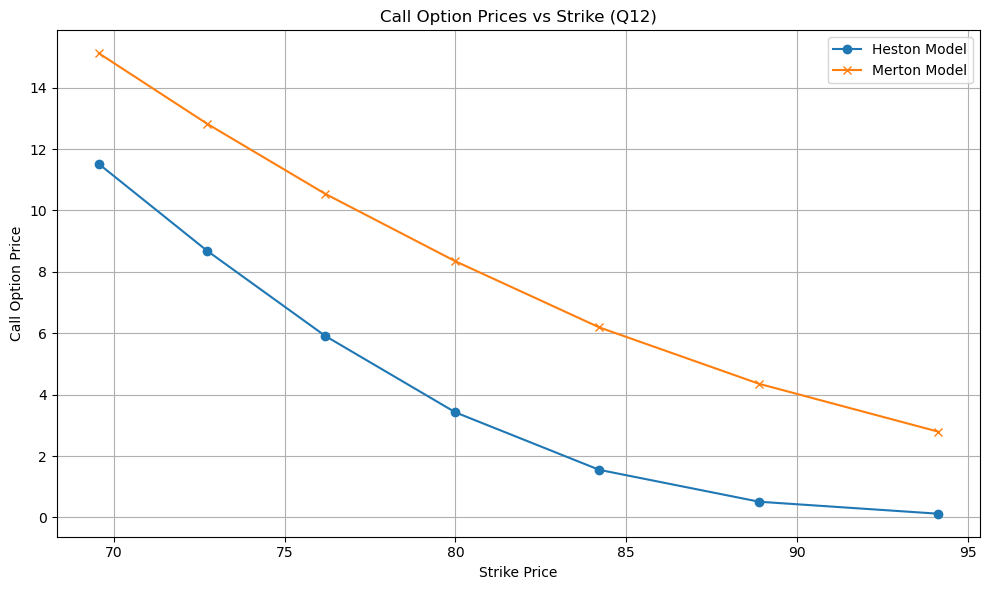

In [15]:
import matplotlib.pyplot as plt

# Plotting the call option prices for both models
plt.figure(figsize=(10, 6))
plt.plot(result_df["Strike"], result_df["Heston Call Price"], label="Heston Model", marker='o')
plt.plot(result_df["Strike"], result_df["Merton Call Price"], label="Merton Model", marker='x')
plt.title("Call Option Prices vs Strike (Q12)")
plt.xlabel("Strike Price")
plt.ylabel("Call Option Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
